# Example workflow : document tagger

This notebook proposes a comprehensive example of "workflows" or "LLM agents" created using the new `Node` API.
This framework is inspired by multiple other frameworks, like `LangGraph`, `llama-index`, `agent development kit (ADK)`.
The major distinction is that the proposed implementation is much simpler than the existing libraries, therefore proposing less features, but being much simpler to use, implement and extend.

The provided use case is a document tagger : given a file (`docs`, `pdf` or any other format supported by `utils.text.parse_document`), and a list of tags with their descriptions, the workflow will attribute most relevant tags to the file.

Such document tagging can be performed using multiple approaches depending on the size of the document and the capabilities of the underlying AI model.
This notebook will explore multiple implementations with increasing level of complexity, to illustrate how to fully exploit the workflow framework.

## Initialization

The first step is to initialize model and define the tags with their criteria. In this example, I have defined a list of tags related to Large Language Models, and used the [MMaDA: Multimodal Large Diffusion Language Models](https://arxiv.org/abs/2505.15809) paper.
This paper proposes a novel open-sourced 8B multimodal diffusion model, probably english-only as multilingual is not explicitel stated.
The objective from the different workflow approaches will be to output the correct tags : `[llm, diffusion, multimodal, reasoning, open, small, mmlu, mmmu, math]`

In [3]:
import os
import re
import time
import json

from utils import *
from utils.text import parse_document
from models.nlu import TextGenerator
from models.nlu.workflows import *

filename = '../../mmada.pdf'

tags = {
    'llm' : 'if the paper presents a new large language model.',
    'cnn' : 'if the paper proposes a new convolutional neural network.',
    
    'diffusion'  : 'if the paper proposes a new diffusion model',
    'ar' : 'if the paper proposes an autoregressive architecture',

    'reasoning'  : 'if the proposed model is a reasoning model (i.e., reasoning has been included during training)',
    'multimodal' : 'if the paper proposes a new multimodal language model',
    'multilingual' : 'if the proposed model is multilingual',

    'open' : 'if the proposed model is open-source',
    
    'small': 'if the model is 15B parameters or smaller',
    'medium' : 'if the model is between 15 and 40B parameters',
    'big'    : 'if the model is bigger than 50B parameters',

    'mmlu' : 'if the MMLU dataset has been used for evaluation',
    'mmmu' : 'if the MMMU dataset has been used for evaluation',
    'math' : 'if the MATH dataset has been used for evaluation',

}

In [ ]:
model_name = 'meta-llama/Meta-Llama-3.1-8B-Instruct'
model_dir = model_name.split('/')[1].replace('-', '_') + '_int8_engine'
path = os.path.expanduser('~/.cache/tensorrt_llm/{}/'.format(get_module_version('tensorrt_llm'))) + model_dir
name = 'trtllm-{}_'.format(get_module_version('tensorrt_llm')) + model_dir.lower()

model = TextGenerator(
    lang = 'multi',
    name = name,
    tokenizer = model_name,
    
    path = path,
    runtime = 'trt_llm',
    kv_cache_free_gpu_memory = 2048, # this limits kv-cache memory to 2Gb
    kv_cache_enable_block_reuse = True # this enables kv-cache reuse
)

## Example 1 : naïve tagger implementation

This first example asks the LLM to outputs the list of relevant tags based on the first page.
The paper is 37 pages long, which is far too long for the model limited context window.
Therefore, providing the first page (which contains the abstract) is a typical design choice.

### Solution 1 : manual parsing and execution

This first example simply parses the document, extracts the first page, and forwards it to the `model.infer` method.
This illustrates a regular manual implementation of the naïve tagger.

In this basic example, the model provides some of relevant tags, but fails on datasets and model size,
as the information is not reported in the first page.
Additionally, you have to parse the output with regular expressions to get the final list of tags.

In [5]:
paragraphs = parse_document(filename)
print('# paragraphs : {} - # pages : {}'.format(len(paragraphs), paragraphs[-1]['page'] + 1))

first_page = [p for p in paragraphs if p['page'] == 0]
print('# paragraphs in 1st page : {}'.format(len(first_page)))

# paragraphs : 734 - # pages : 37
# paragraphs in 1st page : 13


In [6]:
prompt = f"""
Output the relevant list of tags for the provided paper page(s).

Here is the list of tags with their criteria : {json.dumps(tags, indent = 4)}

You have to output a valid python list : `["tag 1", "tag 2", ...]`
"""

output = model.infer(
    prompt,
    lang = 'en',
    paragraphs = first_page,
    answer_start = "The relevant tags are : `[",
    stop_condition = lambda text: text.rstrip().endswith('`'),
    messages = []
)

print('Input prompt :\n{}\n\n{}\nOutput :\n{}'.format(
    output['prompt'], '=' * 50, output['predicted']
))

[TRT-LLM] 25 tokens generated in 621 ms (40.216 tokens/sec)
Input prompt :
<|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 01 August 2025

## Personality

You are an AI assistant. You must respond as best as possible to user requests.

## Information

You have access to this information to help you respond. **Use it if it's relevant**!

- File: ../../mmada.pdf
- Page #0
MMaDA: Multimodal Large Diffusion Language Models

Ling Yang^1,^4∗†, Ye Tian^2∗, Bowen Li^2, Xinchen Zhang^3,
 Ke Shen^4, Yunhai Tong^2, Mengdi Wang^1
^1 Princeton University ^2 Peking University ^3 Tsinghua University ^4 ByteDance Seed

∗ Equal Contribution

arXiv:2505.15809v1 [cs.CV] 21 May 2025

Abstract

We introduce  MMaDA, a novel class of multimodal diffusion foundation models designed to achieve
superior performance across diverse domains such as textual reasoning, multimodal understanding,
 and text-to-image generation. The approach is distinguished by three key inn

In [7]:
tags_list = re.findall('"(.*?)"', output['predicted'])
print('Tags : {}'.format(tags_list))

Tags : ['llm', 'diffusion', 'multimodal', 'reasoning', 'open', 'big']


### Solution 2 : workflow-based implementation

This example reproduces the previous manual implementation by using workflows to automate file parsing and tags extraction to python list.
The output is identical to the previous example, except that it is a regular python list containing the tags, making it easier to manipulate !

Workflow explanation :
- The `Graph` is an alias for `SequentialExecution`. It basically executes a list of nodes one after the other.
- The `DocumentNode` calls `parse_document` on its input file.
    - The `source_key` represents the key in the context for the filename input.
    - The `output_key` is the context key where the output will be stored.
    - This is quivalent to `context['output_key'] = parse_document(context['source_key'])`
- The `FunctionNode` simply executes a function, taking the `context` as argument.
- The `LLMNode` executes the `model.infer` method based on the given arguments.
    - The `source_key` represents the input text (the prompt).
    - The `mapping` maps context keys to kwarg name. In this case, the "first_page" argument will be forwarded as "paragraphs" kwarg.
    - The `keep_history` tells whether or not the model uses conversation history.
- The `TextExtractorNode` parses the input text with regular expression. In this case, it extracts all texts between quotes and put them in a list.

The core feature of this framework is that the `Graph` object is an instance of `Node` like any other `Node` in the graph.
This means that you can execute manually each node, as shown in the below examples.

In [15]:
tagger = Graph(
    DocumentNode(source_key = 'filename', output_key = 'paragraphs'),
    FunctionNode(
        lambda context: [para for para in context['paragraphs'] if para['page'] == 0],
        output_key = 'first_page'
    ),
    LLMNode(
        model = model,
        lang  = 'en',
        answer_start = "The relevant tags are : `[",
        stop_condition = lambda text: text.rstrip().endswith('`'),
        keep_history   = False,
        
        mapping    = {'first_page' : 'paragraphs'},
        source_key = 'prompt',
        output_key = 'llm_tags'
    ),
    TextExtractorNode(
        pattern = '"(.*?)"', source_key = 'llm_tags', output_key = 'result'
    )
)

ctx, result = tagger.start({'filename' : filename, 'prompt' : prompt})
print(result)

[LLM] Time-to-first token : 19 ms
[LLM] 25 tokens generated in 271 ms (91.926 tokens/sec)
['llm', 'diffusion', 'multimodal', 'reasoning', 'open', 'big']


#### Sub-graph execution

This example executes the `LLMNode` followed by the `TextExtractorNode` as functions by manually providing the context.
This allows to check the correct behavior of each individual part of the workflow.

The `context` is updated in-place, meaning that it can be forwarded to each successive call !

In [20]:
ctx = {'prompt' : prompt, 'first_page' : first_page}

llm_tags = tagger.nodes[2](ctx)
print('Output of LLMNode : {}\n- Context keys : {}'.format(llm_tags, tuple(ctx.keys())))

result = tagger.nodes[-1](ctx)
print('Final output (type {}) : {}\n- Context keys : {}'.format(type(result), result, tuple(ctx.keys())))

[LLM] Time-to-first token : 19 ms
[LLM] 25 tokens generated in 273 ms (91.504 tokens/sec)
Output of LLMNode : The relevant tags are : `[ "llm", "diffusion", "multimodal", "reasoning", "open", "big" ]`
- Context keys : ('prompt', 'first_page', 'llm_tags')
Final output (type <class 'list'>) : ['llm', 'diffusion', 'multimodal', 'reasoning', 'open', 'big']
- Context keys : ('prompt', 'first_page', 'llm_tags', 'result')


#### Workflow plot

The base `Node` class implements the `plot` method. Each node can override the `plot_node` to define a custom plotting strategy,
like `Graph` that plots each sub-nodes as a sequence.
As shown in the plot, this workflow is purely sequential

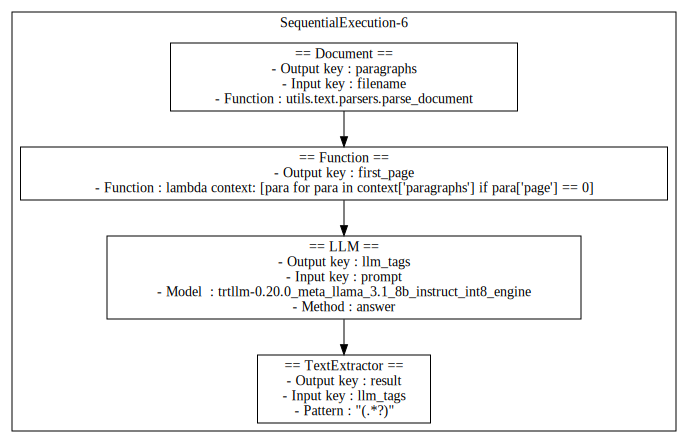

In [17]:
tagger.plot()

## Example 2 : multi-pages tagging

In this second example, the LLM will be executed on each page separately, and all the selected tags will then be combined.

### Solution 1 : manual parsing and execution

This first example simply parses the document, extracts the first page, and forwards it to the `model.infer` method.
This illustrates a regular manual implementation of the naïve tagger.

For simplicity, only the 18 first pages will be processed, as the remaining ones are references and appendixes with examples.

In this second example, the model provides some of relevant tags, including some of the datasets.
However, sequentially processing all the pages is relatively slow and may be optimized though parallelization.

In [6]:
def group_paragraphs(paragraphs, nb_pages = 2):
    """
        Group paragraphs into block of pages.
        `output[i]` is the list of paragraphs ofr page indexes `range(i, i + nb_pages)`
    """
    pages = {}
    for para in paragraphs:
        pages.setdefault(para['page'], []).append(para)

    groups = []
    for i, (page, content) in enumerate(sorted(pages.items())):
        if i % nb_pages == 0:
            groups.append(content)
        else:
            groups[-1].extend(content)
    
    return groups

paragraphs = parse_document(filename)
print('# paragraphs : {} - # pages : {}'.format(len(paragraphs), paragraphs[-1]['page'] + 1))

pages = group_paragraphs(paragraphs, 2)
print('# paragraphs in pages 1 and 2 : {}'.format(len(pages[0])))

# paragraphs : 734 - # pages : 37
# paragraphs in pages 1 and 2 : 43


In [8]:
prompt = f"""
Output the relevant list of tags for the provided paper page(s).

Here is the list of tags with their criteria : {json.dumps(tags, indent = 4)}

You have to output a valid python list : `["tag 1", "tag 2", ...]`
"""

t0 = time.time()

selected_tags = set()
for i, pages_content in enumerate(pages[:9]):
    output = model.infer(
        prompt,
        lang = 'en',
        paragraphs = pages_content,
        answer_start = "The relevant tags are : `[",
        stop_condition = lambda text: text.rstrip().endswith('`'),
        messages = []
    )
    tags_list = re.findall('"(.*?)"', output['predicted'])
    print('Tags for group #{} : {}'.format(i, tags_list))   
    selected_tags.update(tags_list)

print('All tags selected (time {}) : {}'.format(time_to_string(time.time() - t0), selected_tags))

[TRT-LLM] 30 tokens generated in 608 ms (49.330 tokens/sec)
Tags for group #0 : ['llm', 'diffusion', 'multimodal', 'reasoning', 'multimodal', 'open', 'medium']
[TRT-LLM] 18 tokens generated in 544 ms (33.083 tokens/sec)
Tags for group #1 : ['multimodal', 'reasoning', 'diffusion', 'ar']
[TRT-LLM] 18 tokens generated in 588 ms (30.611 tokens/sec)
Tags for group #2 : ['reasoning', 'multimodal', 'diffusion', 'ar']
[TRT-LLM] 18 tokens generated in 553 ms (32.543 tokens/sec)
Tags for group #3 : ['reasoning', 'multimodal', 'diffusion', 'ar']
[TRT-LLM] 29 tokens generated in 788 ms (36.789 tokens/sec)
Tags for group #4 : ['llm', 'multimodal', 'reasoning', 'multimodal', 'mmlu', 'mmmu']
[TRT-LLM] 21 tokens generated in 500 ms (41.939 tokens/sec)
Tags for group #5 : ['diffusion', 'multimodal', 'reasoning', 'open', 'medium']
[TRT-LLM] 10 tokens generated in 494 ms (20.231 tokens/sec)
Tags for group #6 : ['reasoning', 'diffusion']
[TRT-LLM] 20 tokens generated in 548 ms (36.470 tokens/sec)
Tags for

### Solution 2 : workflow based implementation

This implementation reproduces the manual one while integrating parallelization to process multiple pages in parallel.
Note that the arguments used during model initialization/engine construction limit the kv-cache memory available, and thus the number of
inference it can perform in parallel. It is the reason why some generations start after others are finished. 
Nonetheless, the total time to process the 18 pages is less than 3 sec, compared to the 5.46 sec from the previous sequential execution !

Workflow explanation :
- The `DocumentNode` is equivalent to the naive example.
- The `FunctionNode` uses the `source_key` argument to get the effective paragraphs as first argument instead of the context.
- The `IteratorNode` is an abstraction, declined in `SequentialIteratorNode ` or `ParallelIteratorNode`. Passing `parallel = True` is equivalent to using the `ParallelIteratorNode` class directly.
    - The `body` is the function (or node) executed on each item from the iterable
    - The `iterable` is either the context key to use as iterable (like in this case) either an iterable (like a regular list)
    - The `item_key` is the context key in which the current item will be stored. In the case of parallel execution, each call to `body` will have a copy of the context.
    - The output from the `ParallelIteratorNode` is the list of individual result (i.e., `[body(item) for item in iterable]`)
- The final `FunctionNode` simply combines all tags from each page

In [11]:
def group_paragraphs(paragraphs, nb_pages = 2, n_groups = 9):
    """
        Group paragraphs into block of pages.
        `output[i]` is the list of paragraphs ofr page indexes `range(i, i + nb_pages)`
    """
    pages = {}
    for para in paragraphs:
        pages.setdefault(para['page'], []).append(para)

    groups = []
    for i, (page, content) in enumerate(sorted(pages.items())):
        if i % nb_pages == 0:
            groups.append(content)
        else:
            groups[-1].extend(content)
    
    return groups[:n_groups]

def combine_tags(tags_list):
    union = set()
    for tags in tags_list: union.update(tags)
    return union

tagger = Graph(
    DocumentNode(source_key = 'filename', output_key = 'paragraphs'),
    FunctionNode(group_paragraphs, nb_pages = 2, source_key = 'paragraphs', output_key = 'pages'),
    IteratorNode(
        parallel = True,
        
        body = Graph(
            LLMNode(
                model = model,
                lang  = 'en',
                answer_start = "The relevant tags are : `[",
                stop_condition = lambda text: text.rstrip().endswith('`'),
                keep_history   = False,
                
                mapping    = {'page_content' : 'paragraphs'},
                source_key = 'prompt',
                output_key = 'llm_tags'
            ),
            TextExtractorNode(
                pattern = '"(.*?)"', source_key = 'llm_tags'
            )
        ),
        iterable = 'pages',
        item_key = 'page_content',
        output_key = 'tags_list'
    ),
    FunctionNode(combine_tags, source_key = 'tags_list', output_key = 'result')
)

t0 = time.time()
ctx, result = tagger.start(filename = filename, prompt = prompt)

print('All tags selected (time {}) : {}'.format(time_to_string(time.time() - t0), result))

[LLM] Time-to-first token : 185 ms
[LLM] Time-to-first token : 664 ms
[LLM] Time-to-first token : 677 ms
[LLM] 18 tokens generated in 877 ms (20.513 tokens/sec)
[LLM] Time-to-first token : 1.037 sec
[LLM] 21 tokens generated in 1.097 sec (19.147 tokens/sec)
[LLM] 20 tokens generated in 1.067 sec (18.746 tokens/sec)
[LLM] Time-to-first token : 1.446 sec
[LLM] Time-to-first token : 1.434 sec
[LLM] 10 tokens generated in 1.559 sec (6.415 tokens/sec)
[LLM] Time-to-first token : 1.780 sec
[LLM] 18 tokens generated in 1.878 sec (9.586 tokens/sec)
[LLM] Time-to-first token : 2.073 sec
[LLM] 18 tokens generated in 2.114 sec (8.513 tokens/sec)
[LLM] Time-to-first token : 2.361 sec
[LLM] 18 tokens generated in 2.555 sec (7.045 tokens/sec)
[LLM] 30 tokens generated in 2.635 sec (11.385 tokens/sec)
[LLM] 29 tokens generated in 2.683 sec (10.808 tokens/sec)
All tags selected (time 2.951 sec) : {'medium', 'diffusion', 'big', 'multimodal', 'reasoning', 'open', 'ar', 'llm', 'mmlu', 'mmmu'}


#### Workflow plot

This new workflow has a much funnier plot ! It well represents the parallel execution of item generation and call to `body`.

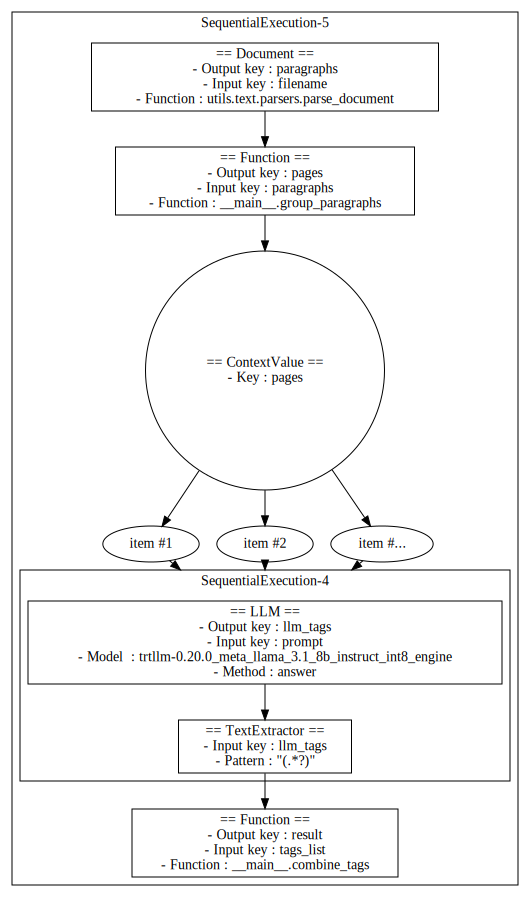

In [12]:
tagger.plot()